# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [2]:
from unityagents import UnityEnvironment
import numpy as np
from workspace_utils import active_session
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from agent import Agent
import time
plt.ion()

In [3]:
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


In [6]:
def ddpg(n_episodes=300, max_t=500):
    avg_score = []
    scores_deque = deque(maxlen=100)
    scores = np.zeros(num_agents)
    time_steps = 20
    update = 10
    
    solved = False
    env_info = env.reset(train_mode=True)[brain_name]
    
    states = env_info.vector_observations
    
    agent_tuple = {"state_size": state_size, "action_size": action_size, "random_seed": 2,}
    agents = [Agent(**agent_tuple) for _ in range(num_agents)]
    action = [agent.act(states[i]) for i, agent in enumerate(agents)]   
    
    for i_episode in range(1, n_episodes+1):
        states = env_info.vector_observations                 
        for agent in agents:
            agent.reset()

        for t in range(max_t):
            actions = [agent.act(states[i]) for i, agent in enumerate(agents)]            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                         
            dones = env_info.local_done                       
            
            step_t = zip(agents, states, actions, rewards, next_states, dones)
            
            for agent, state, action, reward, next_step, done in step_t:
                agent.memory.add(state, action, reward, next_step, done)
                if ( t % time_steps == 0):
                    agent.step(state, action, reward, next_step, done, update)
            states  = next_states
            scores += rewards                                  
            if np.any(dones):                                 
                break
                
        score = np.mean(scores)        
        avg_score.append(score)
        scores_deque.append(score)
        avg = np.mean(scores_deque)            
            
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg,), end="\n")

        if not solved and np.mean(scores_deque) > 30.:
            print("\r\rEnviroment solved in @ i_episode={i_episode}, w/ avg_score={avg:.2f}\r".format(i_episode=i_episode, avg=avg))
            solved= True

    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    
    return avg_score

In [8]:
# agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
scores = ddpg()

Episode 1	Average Score: 0.00
Episode 2	Average Score: 0.41
Episode 3	Average Score: 0.55
Episode 4	Average Score: 0.61
Episode 5	Average Score: 0.66
Episode 6	Average Score: 0.68
Episode 7	Average Score: 0.73
Episode 8	Average Score: 0.82
Episode 9	Average Score: 0.88
Episode 10	Average Score: 0.94
Episode 11	Average Score: 1.02
Episode 12	Average Score: 1.10
Episode 13	Average Score: 1.18
Episode 14	Average Score: 1.24
Episode 15	Average Score: 1.30
Episode 16	Average Score: 1.37
Episode 17	Average Score: 1.46
Episode 18	Average Score: 1.54
Episode 19	Average Score: 1.64
Episode 20	Average Score: 1.74
Episode 21	Average Score: 1.83
Episode 22	Average Score: 1.91
Episode 23	Average Score: 2.01
Episode 24	Average Score: 2.10
Episode 25	Average Score: 2.19
Episode 26	Average Score: 2.28
Episode 27	Average Score: 2.37
Episode 28	Average Score: 2.45
Episode 29	Average Score: 2.52
Episode 30	Average Score: 2.59
Episode 31	Average Score: 2.67
Episode 32	Average Score: 2.75
Episode 33	Averag

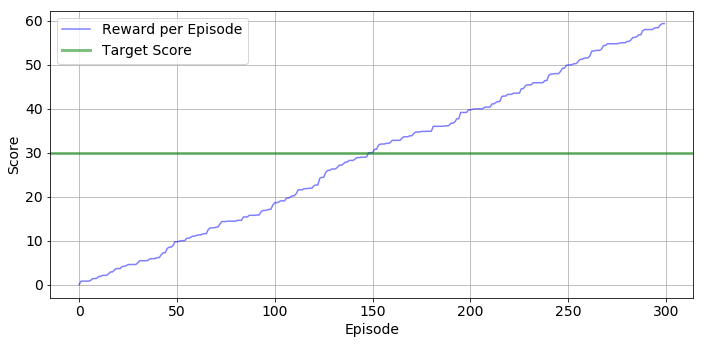

In [10]:
fig, ax = plt.subplots(1, 1, figsize=[10, 5])
plt.rcParams.update({'font.size': 14})

ax.plot(scores, "-", c="blue", alpha=0.5)
ax.set_xlabel("Episode")
ax.set_ylabel("Score")
ax.grid(which="major")
ax.axhline(30, c="green", linewidth=3, alpha=0.5)
ax.legend(["Reward per Episode", "Target Score"])

fig.tight_layout()
fig.savefig("plot.jpg")

In [ ]:
env.close()